In [10]:
import pymc as pm
import numpy as np
import pytensor as pt
import pytensor.tensor as tt
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
s = []
for i in np.arange(347):
    s.append(str(i))

In [3]:
data = pd.read_csv('EVI.csv', header=0, names=s)

In [4]:
data

,0,1,2,3,4,5,6,7,8,9,...,337,338,339,340,341,342,343,344,345,346
0,0.4560,NaN,0.3975,0.3183,0.3022,0.2870,0.2886,0.2236,0.2318,0.1911,...,0.2832,0.3471,0.3432,NaN,0.3971,0.4401,0.3606,0.3702,0.4172,0.4218
1,0.4652,NaN,0.3807,0.3194,0.2936,0.2985,0.2810,0.2221,0.2281,0.1891,...,0.2933,0.3547,0.3450,NaN,0.4069,0.4418,0.3606,0.3621,NaN,0.4294
2,0.4642,NaN,0.3748,0.3107,0.2918,0.3008,0.2810,0.2221,0.2277,0.1851,...,0.2804,0.3445,0.3450,NaN,0.4032,0.4490,0.3527,0.3750,NaN,0.4099
3,0.4576,NaN,0.3624,0.3076,0.2811,0.3083,0.2754,0.2134,0.2194,0.1820,...,0.2998,0.3517,0.3450,NaN,0.4006,0.4494,0.3551,0.3586,NaN,0.4326
4,0.4468,NaN,0.3600,0.2974,0.2681,0.3129,0.2698,0.2099,0.2194,0.1773,...,0.2891,0.3464,0.3468,NaN,0.3861,0.4378,0.3388,0.3273,NaN,0.4228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11295,0.4263,NaN,0.3711,0.3008,0.2867,0.3200,0.2856,0.2336,0.2417,0.2061,...,0.3174,0.4838,0.2843,NaN,0.3790,0.4730,0.4753,0.3612,0.4667,0.4319
11296,0.4412,NaN,0.3804,0.3055,0.3123,0.2833,0.2856,0.2278,0.2267,0.1967,...,0.2627,0.2769,0.1956,NaN,0.1590,0.3577,0.3272,0.6130,0.8339,0.6045
11297,0.4610,NaN,0.3835,0.3165,0.3134,0.2578,0.2923,0.2326,0.2267,0.1927,...,0.1562,0.1554,0.1581,NaN,0.1512,0.1602,0.3670,0.6244,0.8663,0.7845
11298,0.4566,NaN,0.3876,0.3174,0.3208,0.2883,0.2869,0.2288,0.2263,0.1930,...,0.1645,0.1945,0.1680,NaN,0.2586,NaN,0.3687,0.5850,0.5896,0.7060


In [5]:
def inpaint_nans(data):
    """
    Inpaint NaNs in a DataFrame using linear interpolation.
    """
    return data.interpolate(method='linear', limit_direction='both', axis=0)

In [7]:
testSeries = data.iloc[0]

In [9]:
testSeries = inpaint_nans(testSeries)

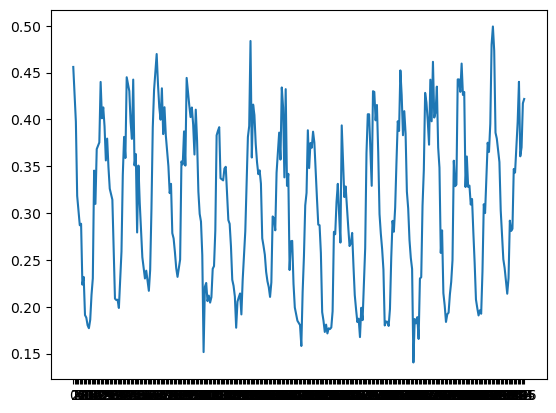

In [11]:
plt.plot(testSeries)

In [ ]:
coords = {'timeSerieslength': np.arange(len(testSeries)),
          'samplesPerYear': 23}

In [ ]:
with pm.Model(coords=coords) as model:
    x = pm.Uniform("x", lower=0, upper=1, shape='samplesPeryear')



In [ ]:
#%% Model definition
basic_model = pm.Model()
samplesPerYear = 23 #Number of datapoints per year
sigma_err_prior = 1/0.05 #Estimate of EVI error variance
dummyData = np.zeros([0])
shared_data = T.shared(dummyData, borrow=True) #Sahred data definition - Theano

#%% Model definition
with basic_model:
        ## prior for 15-day EVI, U(0-1)
        x = pm.Uniform("x", 0, 1, shape=samplesPerYear)
        x = Tensor.cast(x, 'float64') #required for theano
        
        ## prior for observation process, Exp(sigma_err_prior)
        sigma_err = pm.Exponential("sigma_err", sigma_err_prior)

        @T.compile.ops.as_op(itypes=[Tensor.dvector],otypes=[Tensor.dvector]) #original
        def loredo(x = x, profile=True):
            L = shared_data.get_value(borrow=True).shape[0]
            out = np.zeros(L)
            k = 0
            while True:
                if (k+1)*samplesPerYear < L:
                    out[k*samplesPerYear:(k+1)*samplesPerYear] = x[0:samplesPerYear]
                    k = k+1
                else:
                    diff = (k+1)*samplesPerYear - L
                    out[k*samplesPerYear:(k+1)*samplesPerYear-diff] = x[0:samplesPerYear-diff]
                    break
            return out  
        loredo.grad = lambda *y: y[0]  # Here's the klutz, llama al grad pero es un bug
        loredo.shape = shared_data.get_value(borrow=True).shape[0]    
               
        ## likelihood
        observation = pm.Normal("obs", mu=loredo(x), tau=1/sigma_err, observed=shared_data)

In [127]:
def loredo_det(x, t, samplesPerYear):
    L = t
    out = np.zeros(L)
    k = 0
    while True:
        if (k+1)*samplesPerYear < L:
            # print(k*samplesPerYear)
            # print((k+1)*samplesPerYear)
            out[k*samplesPerYear:(k+1)*samplesPerYear] = x[0:samplesPerYear]
            k = k+1
        else:
            diff = (k+1)*samplesPerYear - L
            # print(k*samplesPerYear)
            # print((k+1)*samplesPerYear-diff)
            out[k*samplesPerYear:(k+1)*samplesPerYear-diff] = x[0:samplesPerYear-diff]
            break         
    return out  

In [128]:
t = 200
x = testSeries[:23]
samplesPerYear = 23
aux = loredo_det(x, t, samplesPerYear)

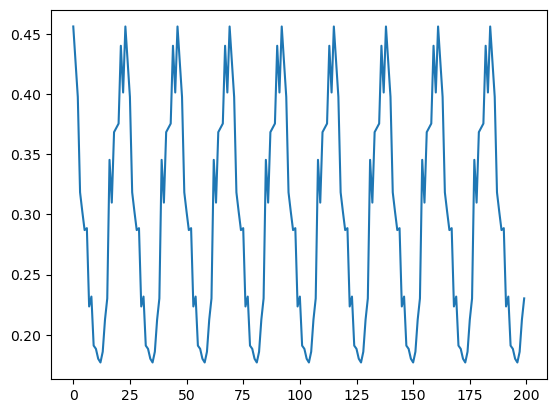

In [129]:
plt.plot(aux)

In [125]:
# #%% Model definition
# with pm.Model() as model:
#         ## prior for 15-day EVI, U(0-1)
#         x = pm.Uniform("x", 0, 1, shape=samplesPerYear)
#         # print(x[0:4].eval())
#         # print(samplesPerYear)
#         y = loredo_det(x, t, samplesPerYear)

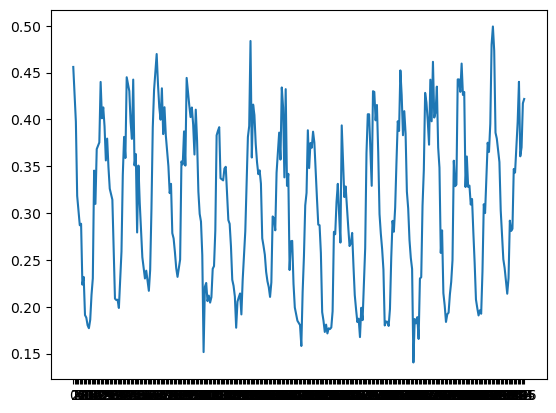

In [131]:
plt.plot(testSeries)

In [143]:
t = len(testSeries)

In [144]:
len(testSeries)

347

In [190]:
t = len(testSeries)

datos de entrenamiento

In [217]:
trainData = testSeries[:100]
t = len(trainData)

version concat (esta anda)

In [288]:
#%% Model definition
sigma_err = 0.025

with pm.Model() as model:
        ## prior for 15-day EVI, U(0-1)
        x = pm.Uniform("x", 0, 1, shape=samplesPerYear)
        # y = pm.Uniform("y", 0, 1, shape=0)
        y = []
        # print(x[0:4].eval())
        # print(samplesPerYear)

        ciclos = (t) // (samplesPerYear)
        resto = (t) % (samplesPerYear)

        # print(ciclos)
        # print(resto)

        for i in range(ciclos):
            # y = pm.math.concatenate([y, x], axis=0) 
            y = pm.math.concatenate([y, x], axis=0) 
        
        y = pm.math.concatenate([y, x[0:resto]], axis=0)
        # print(x.shape.eval())
        obs = pm.Normal("obs", mu=y, sigma=sigma_err, observed=trainData)

        

In [289]:
with model:
    print(y.shape.eval())

[100]


In [290]:
with model:
    pm.sample_prior_predictive()

Sampling: [obs, x]


In [291]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [292]:
trace.posterior.x

<xarray.DataArray 'x' (chain: 4, draw: 1000, x_dim_0: 23)>
array([[[0.42439135, 0.40148438, 0.3920626 , ..., 0.40614178,
         0.39518126, 0.42303167],
        [0.41274705, 0.3790775 , 0.37026209, ..., 0.41262777,
         0.42225172, 0.38926892],
        [0.4234813 , 0.39478244, 0.39940599, ..., 0.39510849,
         0.38869474, 0.42543065],
        ...,
        [0.41442598, 0.38914047, 0.38551501, ..., 0.42030067,
         0.40427175, 0.41176257],
        [0.397057  , 0.39046396, 0.38565027, ..., 0.40919005,
         0.40859465, 0.4094332 ],
        [0.40600063, 0.39800272, 0.36442217, ..., 0.40364115,
         0.42742227, 0.39499306]],

       [[0.41801091, 0.38934217, 0.38609507, ..., 0.42296017,
         0.41332466, 0.39867446],
        [0.41569656, 0.38849797, 0.38158623, ..., 0.40062773,
         0.39711489, 0.4115117 ],
        [0.41525518, 0.3979609 , 0.39294584, ..., 0.41034454,
         0.39319274, 0.40892716],
...
        [0.44111127, 0.38789516, 0.4020712 , ..., 0.39486394,
         0.4087057 , 0.44247331],
        [0.39672772, 0.38413297, 0.36909497, ..., 0.38590401,
         0.41696806, 0.37437914],
        [0.43292472, 0.40465314, 0.3621877 , ..., 0.38551143,
         0.39258709, 0.41857171]],

       [[0.41836016, 0.38815979, 0.37711352, ..., 0.38968088,
         0.39530035, 0.41968984],
        [0.42899464, 0.38853086, 0.38068507, ..., 0.38430878,
         0.39774987, 0.42062121],
        [0.40098718, 0.39416686, 0.387664  , ..., 0.43275706,
         0.41037192, 0.39075309],
        ...,
        [0.41472334, 0.39289258, 0.38512711, ..., 0.43022186,
         0.39003369, 0.41853685],
        [0.42438736, 0.38668652, 0.38056068, ..., 0.38696893,
         0.4272024 , 0.39437777],
        [0.42643919, 0.39392402, 0.38840727, ..., 0.41264156,
         0.41616671, 0.4215377 ]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22

In [293]:
stacked = trace.posterior.x.stack(desired=['chain', 'draw']).values

In [294]:
x_mean = stacked.mean(axis=1)

In [295]:
reco = loredo_det(x_mean, t, samplesPerYear)

In [296]:
import plotly.express as px


fig = px.line(y=[trainData, reco])
fig.show()
fig = px.line(y=testSeries)


# fig = px.line(y=reco)

# fig = px.line(y=testSeries)



prediccion

In [307]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["obs"])

Sampling: [obs]


In [308]:
ppc.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 1000, obs_dim_2: 100)>
array([[[0.38716229, 0.38564496, 0.40741499, ..., 0.25414355,
         0.31940952, 0.27651242],
        [0.391278  , 0.3757138 , 0.39045761, ..., 0.27544343,
         0.35178281, 0.25499739],
        [0.43748784, 0.403953  , 0.37522479, ..., 0.3351097 ,
         0.32605795, 0.21765635],
        ...,
        [0.4271247 , 0.38761572, 0.3474062 , ..., 0.29336276,
         0.31068484, 0.25721194],
        [0.40026586, 0.40494268, 0.40502029, ..., 0.32329533,
         0.25671501, 0.28158029],
        [0.39583931, 0.37829169, 0.3678347 , ..., 0.31468057,
         0.28116951, 0.2493035 ]],

       [[0.38132166, 0.40105811, 0.37306964, ..., 0.28911916,
         0.29385812, 0.29342602],
        [0.44453249, 0.4122148 , 0.38852482, ..., 0.31581256,
         0.28774487, 0.22035722],
        [0.37848019, 0.42419732, 0.37957832, ..., 0.34179504,
         0.2936829 , 0.25267012],
...
        [0.49146186, 0.38869985, 0.41286321, ..., 0.28610649,
         0.27666515, 0.24434209],
        [0.42109797, 0.39485616, 0.38584985, ..., 0.33345321,
         0.30174241, 0.2716814 ],
        [0.41630661, 0.43006053, 0.36264299, ..., 0.34690245,
         0.25553763, 0.30872569]],

       [[0.40293742, 0.38943228, 0.38251517, ..., 0.28892774,
         0.2691353 , 0.27589445],
        [0.46701759, 0.38490746, 0.39461681, ..., 0.30036208,
         0.33046006, 0.22683605],
        [0.38627205, 0.37235371, 0.40822737, ..., 0.33546736,
         0.28305209, 0.20249192],
        ...,
        [0.40462109, 0.38693243, 0.36544207, ..., 0.32755456,
         0.2755636 , 0.27162992],
        [0.42074565, 0.41847434, 0.40469813, ..., 0.27021955,
         0.32976109, 0.27554414],
        [0.41748612, 0.39081819, 0.36504085, ..., 0.25682744,
         0.31233554, 0.28607504]]])
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99

In [309]:
fecha_est = (t+1) % (samplesPerYear)

In [310]:
fecha_est

9

In [311]:
est_ = ppc.posterior_predictive.obs.stack(dim=['chain', 'draw']).values

In [312]:
est = est_[fecha_est,:]

(array([  1.,   2.,   0.,   5.,   3.,   7.,   6.,  16.,  25.,  31.,  34.,
         28.,  59.,  55.,  86.,  92., 113., 133., 149., 140., 191., 185.,
        213., 220., 229., 225., 195., 199., 180., 172., 160., 143., 128.,
        124., 106.,  77.,  66.,  41.,  38.,  32.,  25.,  17.,  13.,  12.,
          9.,   7.,   2.,   3.,   1.,   2.]),
 array([0.12749059, 0.13127477, 0.13505896, 0.13884314, 0.14262732,
        0.14641151, 0.15019569, 0.15397987, 0.15776406, 0.16154824,
        0.16533242, 0.16911661, 0.17290079, 0.17668497, 0.18046916,
        0.18425334, 0.18803752, 0.19182171, 0.19560589, 0.19939007,
        0.20317426, 0.20695844, 0.21074262, 0.21452681, 0.21831099,
        0.22209517, 0.22587936, 0.22966354, 0.23344772, 0.23723191,
        0.24101609, 0.24480027, 0.24858446, 0.25236864, 0.25615282,
        0.25993701, 0.26372119, 0.26750537, 0.27128956, 0.27507374,
        0.27885792, 0.28264211, 0.28642629, 0.29021047, 0.29399466,
        0.29777884, 0.30156302, 0.30534721, 0.

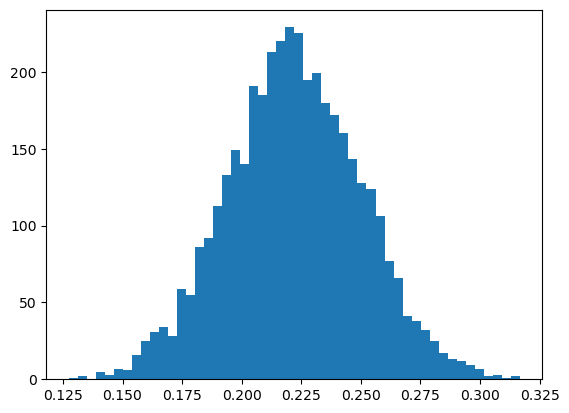

In [313]:
plt.hist(est, bins=50)

<ErrorbarContainer object of 3 artists>

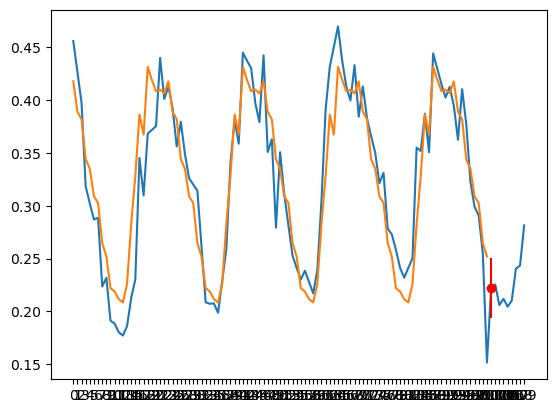

In [314]:
# fig = px.line(y=[trainData, reco])
# fig.show()
# fig = px.line(y=testSeries)

plt.plot(testSeries[:110])
# plt.plot(reco)

reco_ = loredo_det(x_mean, t+1, samplesPerYear)
plt.plot(reco_)

plt.errorbar(x=101, y=est.mean(), yerr=est.std(), fmt='o', color='red')

In [328]:
import plotly.graph_objects as go

fig = go.Figure()

# Línea de testSeries
fig.add_trace(go.Scatter(
    y=testSeries[:110],
    mode='lines',
    name='testSeries'
))

# Línea de reco_
reco_ = loredo_det(x_mean, t + 2, samplesPerYear)
fig.add_trace(go.Scatter(
    y=reco_,
    mode='lines',
    name='reco_'
))

# Punto con barra de error
fig.add_trace(go.Scatter(
    x=[101],
    y=[est.mean()],
    mode='markers',
    name='estimación',
    marker=dict(color='red', size=10),
    error_y=dict(
        type='data',
        array=[est.std()],
        visible=True
    )
))

fig.update_layout(
    title='Loredo estimation t+1',
    xaxis_title='Tiempo',
    yaxis_title='EVI',
    template='plotly_white'
)

fig.show()

(array([2., 1., 1., 2., 3., 1., 1., 0., 2., 2.]),
 array([0.1731 , 0.18162, 0.19014, 0.19866, 0.20718, 0.2157 , 0.22422,
        0.23274, 0.24126, 0.24978, 0.2583 ]),
 <BarContainer object of 10 artists>)

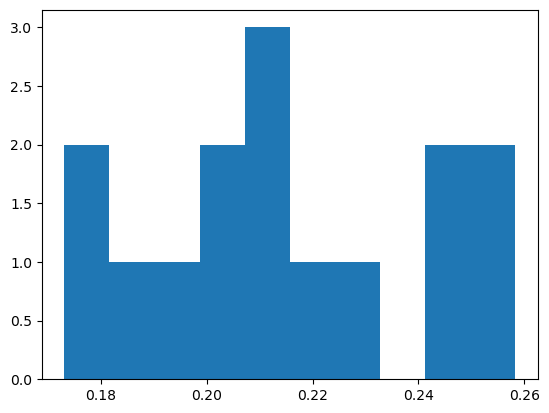

In [324]:
plt.hist(testSeries[9::samplesPerYear])

In [326]:
len(reco_)

101